## Recover Result Utils

In [1]:
"""Utils to load results"""
import os
import pickle

def build_dir_path(missing_type, simulation, graph):
    path = "./"
    if missing_type == "100n":
        path += "missing_output_100_nodes_inf/"
    elif missing_type == "30p":
        path += "missing_output_simulations_30_p_infected/"
    else:
        raise ValueError("No such missing type")

    if simulation in ["si", "sis", "sir"]:
        path += simulation
        path += "/"
    else:
        raise ValueError("No such simulation")
    
    if graph in ["scale_free_100", "scale_free_1000", "synthetic_internet_100", "synthetic_internet_1000", "us_power_grid", "internet"]:
        path += graph
        path += "/"
    return path

def load_results(missing_type, simulation, graph):
    path = build_dir_path(missing_type, simulation, graph)
    
    results_path = os.popen(f"find {path} -name 'results*'").read().replace("\n", "")
    with open(results_path, "rb") as f:
        results = pickle.load(f)
    return results

def load_main_ref_graph(missing_type, simulation, graph):
    path = build_dir_path(missing_type, simulation, graph)
    
    results_path = os.popen(f"find {path} -name 'main_ref_graph*'").read().replace("\n", "")
    with open(results_path, "rb") as f:
        results = pickle.load(f)
    return results

In [2]:
import rumor_centrality.rumor_detection as raw
import rumor_centrality.jordan_center_alternative as jo

metrics = {
    "rumor_centrality" : lambda g: raw.get_center_prediction(
        raw.networkx_graph_to_adj_list(g), use_fact=False
    ),
    "jordan_centrality": jo.centers_by_jordan_center,
    "betweenness_centrality": jo.centers_by_betweenness_centrality,
    "distance_centrality": jo.centers_by_distance_centrality,
}

In [3]:
"""Utils to reconstruct normalized hop distances"""
import networkx as nx
from tqdm import tqdm

def reconstruct_hop_distances(main_ref_graph, results):
    shortest_paths = nx.shortest_path(main_ref_graph)
    def get_best_hop_distance(g, original_centers, predicted_centers):
        best_pair = None
        best_distance = len(g.nodes)
        for o_c in original_centers:
            for p_c in predicted_centers:
                d = len(shortest_paths[o_c][p_c])
                if d < best_distance:
                    best_distance = d
                    best_pair = (o_c, p_c)
        return best_pair, best_distance
    def get_all_hop_distances(g, original_centers, predicted_centers):
        distances = []
        for o_c in original_centers:
            for p_c in predicted_centers:
                distances.append(len(shortest_paths[o_c][p_c]))
        return distances
    
    import statistics
    def get_avg_hop_distance(g, original_centers, predicted_centers):
        return statistics.mean(get_all_hop_distances(g, original_centers, predicted_centers))
    def get_median_hop_distance(g, original_centers, predicted_centers):
        return statistics.median(get_all_hop_distances(g, original_centers, predicted_centers))

    center_results = {}
    for k, v in results.items():
        predicted_centers = []
        for _r in v:
            if _r is None:
                predicted_centers.append((None, None))
            else:
                predicted_centers.append((_r["predicted_centers"], _r["real_centers"]))
        center_results[k] = predicted_centers
    
    def normalize_hop_distances(hop_distances):
        normalized = {}
        for percent_missing, hop_distance_freq in hop_distances.items():
            total_valid = sum(hop_distance_freq.values()) - hop_distance_freq.get(-1, 0)

            normalized_hop_distance_freq = {}
            for hop_distance, freq in hop_distance_freq.items():
                if hop_distance == -1:
                    continue
                normalized_hop_distance_freq[hop_distance] = round(freq / total_valid * sum(hop_distance_freq.values()))
            normalized[percent_missing] = normalized_hop_distance_freq
        return normalized
    
    reference_map = []

    # Map results to hop distances
    hop_distance_freq_by_p_r_by_metric = {}

    for metric_name in metrics.keys():
        hop_distance_freq_by_p_r = {}
        for p_r, values in center_results.items():
            hop_distance_freq = {}
            for i, centers in enumerate(values):
                predicted_centers = centers[0]
                real_centers = centers[1]
                if predicted_centers is None or real_centers is None:
                    hop_distance_freq[-1] = hop_distance_freq.get(-1, 0) + 1
                    reference_map.append((p_r, i, -1))
                else:
                    predicted_centers = predicted_centers[metric_name]
                    
                    # best_pair, best_distance = get_best_hop_distance(main_ref_graph, real_centers, predicted_centers)
                    avg_hop_distance = get_median_hop_distance(main_ref_graph, real_centers, predicted_centers)
                    hop_distance_freq[avg_hop_distance] = hop_distance_freq.get(avg_hop_distance, 0) + 1

                    reference_map.append((p_r, i, avg_hop_distance))

            hop_distance_freq_by_p_r[p_r] = hop_distance_freq
        hop_distance_freq_by_p_r_by_metric[metric_name] = normalize_hop_distances(hop_distance_freq_by_p_r)
    return hop_distance_freq_by_p_r_by_metric

In [4]:
def get_normalized_hop_distances(missing_type, simulation, graph):
    r = load_results(missing_type, simulation, graph)
    main_ref_graph = load_main_ref_graph(missing_type, simulation, graph)
    return reconstruct_hop_distances(main_ref_graph, r)

## Analytical Utils

In [5]:
def get_avg_hop_distances(normalized_hop_distances):
    avgs_hop_distances = {}
    for metric, percent_missing in normalized_hop_distances.items():
        p_lookup = {}
        for p, hop_distances in percent_missing.items():
            avg = sum(list(map(lambda x: x[0] * x[1], hop_distances.items()))) / sum(hop_distances.values())
            p_lookup[p] = avg

        avgs_hop_distances[metric] = p_lookup
    return avgs_hop_distances

## Analyses

In [6]:
from tqdm import tqdm
import pickle
filename = "median_normalized_missing_results.pickle"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
else:
    results = {}
    
    with tqdm(total=2*3*5) as progress_bar:
        for t in ["100n", "30p"]:
            for sim in ["si", "sir", "sis"]:
                for g in ["synthetic_internet_100", "synthetic_internet_1000", "scale_free_100", "scale_free_1000", "us_power_grid"]:
                    r = get_normalized_hop_distances(t, sim, g)
                    results[(t, sim, g)] = r
                    progress_bar.update(1)
    
    with open(filename, "wb") as f:
        pickle.dump(results, f)

In [7]:
import pickle
filename = "median_diameter_normalized_missing_results.pickle"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        diameter_normalized_results = pickle.load(f)
else:
    # Diameter Normalization
    diameter_normalized_results = {}
    for config, metric_hop_distances in results.items():
        diameter_normalized_results[config] = {}

        # first two parameters should be irrelevant
        main_ref_graph = load_main_ref_graph("30p", "si", config[2])
        diameter = nx.diameter(main_ref_graph)
        for metric_name, missing_precent_lookup in metric_hop_distances.items():
            new_missing_precent_lookup = {}
            for missing_percent, hop_distance_lookup in missing_precent_lookup.items():
                new_hop_distance_lookup = dict([
                    (hop_distance / diameter, freq)
                    for hop_distance, freq in hop_distance_lookup.items()
                ])
                new_missing_precent_lookup[missing_percent] = new_hop_distance_lookup

            diameter_normalized_results[config][metric_name] = new_missing_precent_lookup
    with open(filename, "wb") as f:
        pickle.dump(diameter_normalized_results, f)

In [8]:
with open("best_normalized_missing_results.pickle", "rb") as f:
    best = pickle.load(f)

with open("mean_normalized_missing_results.pickle", "rb") as f:
    mean = pickle.load(f)

with open("median_normalized_missing_results.pickle", "rb") as f:
    median = pickle.load(f)

with open("best_diameter_normalized_missing_results.pickle", "rb") as f:
    best_normed = pickle.load(f)

with open("mean_diameter_normalized_missing_results.pickle", "rb") as f:
    mean_normed = pickle.load(f)

with open("median_diameter_normalized_missing_results.pickle", "rb") as f:
    median_normed = pickle.load(f)



In [68]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparative_graph(r):
    interested_results = [
        (config, r)
        for config, r in r.items()
        if (
            config[0] == "30p"
            and config[1] == "si"
            and ("100" not in config[2] or "1000" in config[2])
        )
    ]

    fig, axes = plt.subplots(1, len(interested_results), figsize=(15,5), sharey=True)

    for i, (config, result) in tqdm(enumerate(interested_results)):
        ax = axes[i]
        df = DataFrame(get_avg_hop_distances(result))
        df.plot(title=str(config), ax=ax, legend=False)

        colors = dict([(l.get_label(), l.get_color()) for l in ax.lines])

        for col in df.columns:
            l = sns.regplot(x=df.index, y=df[col], ax=ax, scatter=False, label=f"{col}-reg", color=colors[col])

        for line in ax.lines:
            if "reg" in line.get_label():
                line.set_linestyle(":")
        ax.set_title(config)

        ax.set_xlabel("Missing percent")
        ax.set_ylabel("Diameter Norm. Hop Distance")

        ax.set_ylim([0,1])

    ax.legend(ncol=2, bbox_to_anchor=[0, -0.2]) 


3it [00:00,  4.68it/s]


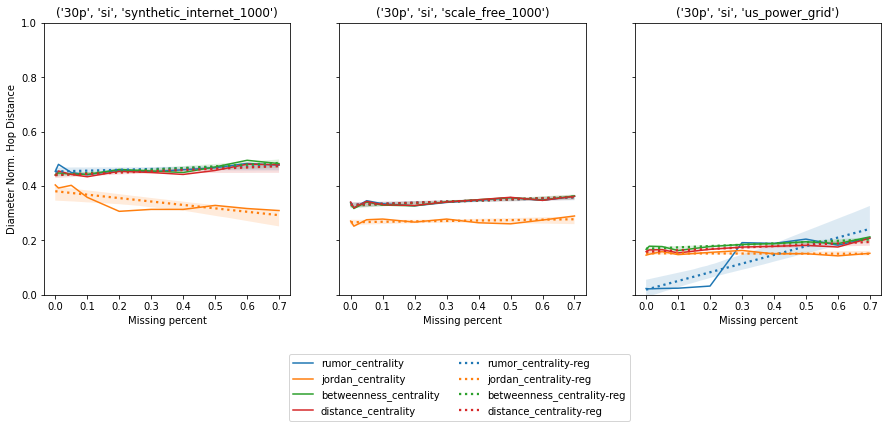

In [69]:
plot_comparative_graph(best_normed)

3it [00:00,  4.58it/s]


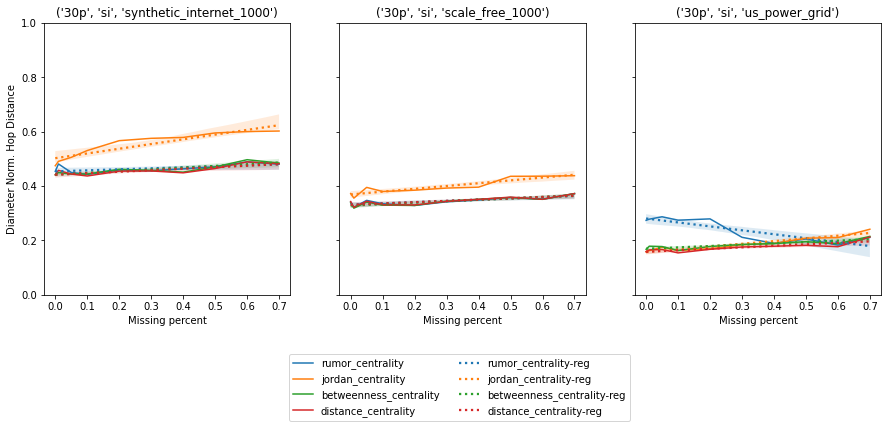

In [11]:
plot_comparative_graph(mean_normed)

3it [00:00,  4.42it/s]


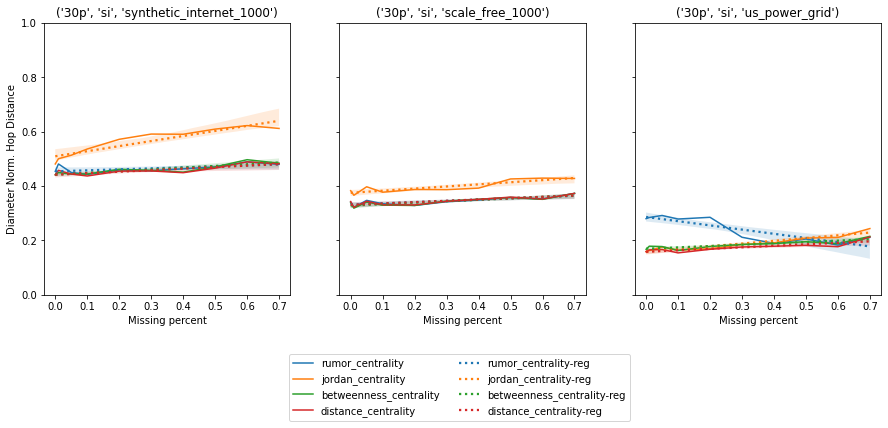

In [12]:
plot_comparative_graph(median_normed)

In [13]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_reg_graphs(r):
    interested_results = [
        (config, r)
        for config, r in r.items()
        if config[0] != "100n" and ("100" not in config[2] or "1000" in config[2])
    ]

    for config, result in tqdm(interested_results):
        if "100n" in config:
            continue
        if "100" in config[2] and "1000" not in config[2]:
            continue

        df = DataFrame(get_avg_hop_distances(result))
        fig, ax = plt.subplots(1,1, figsize=(7,5))
        df.plot(title=str(config), ax=ax)

        colors = dict([(l.get_label(), l.get_color()) for l in ax.lines])

        for col in df.columns:
            l = sns.regplot(x=df.index, y=df[col], ax=ax, scatter=False, label=f"{col}-reg", color=colors[col])

        for line in ax.lines:
            if "reg" in line.get_label():
                line.set_linestyle(":")
        ax.set_title(config)

        ax.set_xlabel("Missing percent")
        ax.set_ylabel("Diameter Norm. Hop Distance")

        ax.legend(ncol=2, bbox_to_anchor=[0.95, -0.15])

        fig

Except for jordan centrality the metrics behave pretty similar, rumor centrality being a bit better. Lets plot rumor centraltiy and jordan centrality next to each other for various graphs.

In [14]:
def plot_metric(results, metric_name, config_filter=lambda config: True, ax=None, legend=False):
    metric_results = {}

    for k, v in results.items():
        metric_results[k] = v[metric_name]

    df = DataFrame(index=metric_results[k].keys())
    for config, result in metric_results.items():
        if config_filter(config) is False:
            continue
        avg = get_avg_hop_distances({"a": result})["a"]
        df[config] = avg.values()
    df.plot(ax=ax, title=metric_name, legend=legend)

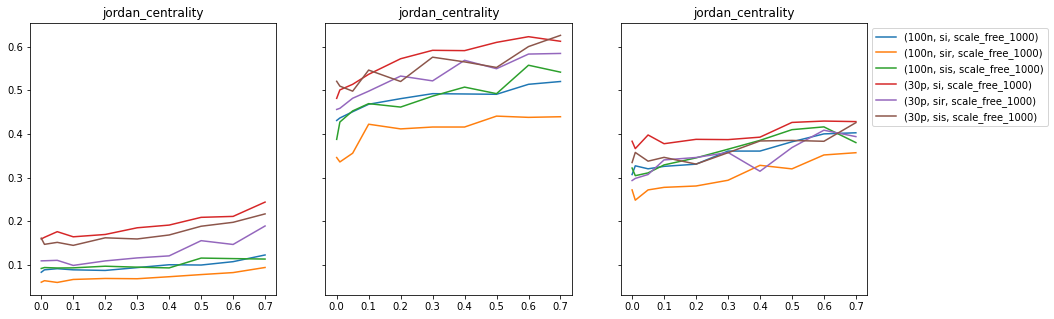

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
plot_metric(diameter_normalized_results, "jordan_centrality", lambda x: x[2] == "us_power_grid", ax=axes[0])
plot_metric(diameter_normalized_results, "jordan_centrality", lambda x: x[2] == "synthetic_internet_1000", ax=axes[1])
plot_metric(diameter_normalized_results, "jordan_centrality", lambda x: x[2] == "scale_free_1000", ax=axes[2])

axes[2].legend(bbox_to_anchor=(1, 1))

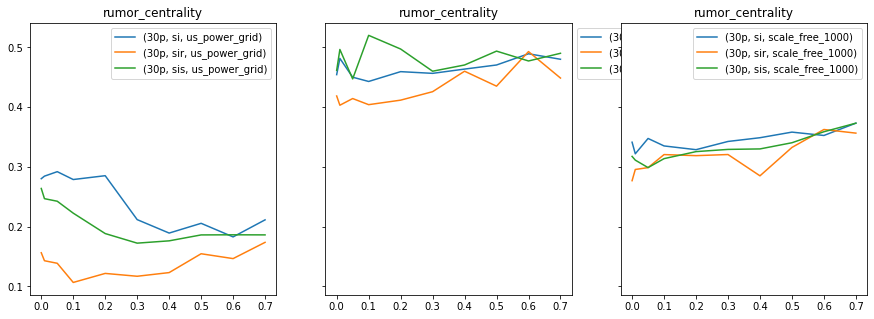

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
plot_metric(diameter_normalized_results, "rumor_centrality", lambda x: x[0] == "30p" and x[2] == "us_power_grid", ax=axes[0])
plot_metric(diameter_normalized_results, "rumor_centrality", lambda x: x[0] == "30p" and x[2] == "synthetic_internet_1000", ax=axes[1])
plot_metric(diameter_normalized_results, "rumor_centrality", lambda x: x[0] == "30p" and x[2] == "scale_free_1000", ax=axes[2])

axes[0].legend(bbox_to_anchor=(1, 1))
axes[1].legend(bbox_to_anchor=(1, 1))
axes[2].legend(bbox_to_anchor=(1, 1))

In [17]:
import seaborn as sns

# Barplot, x: Missing, y: avg. hop distance, plot all graphs for one metric and one simulation type
def metric_graph_compare(results, metric_name, simulation, missing_type, ax=None, legend=False):
    metric_results = {}

    for k, v in results.items():
        metric_results[k] = v[metric_name]

    df = DataFrame(index=metric_results[k].keys())
    for config, result in metric_results.items():
        if simulation not in config or missing_type not in config:
            continue
        avg = get_avg_hop_distances({"a": result})["a"]
        df[config[2]] = avg.values()
    return df

def plot_rumor_against_jordan(results, simulation, missing_type):
    fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
    df = metric_graph_compare(results, "rumor_centrality", simulation, missing_type, ax=axes[0], legend=True)
    df.plot.bar(ax=axes[0])
    for col in df.columns:
        sns.regplot(x=list(range(len(df[col]))), y=df[col], ax=axes[0], scatter=False)
    axes[0].set_title("Rumor Centrality")
    axes[0].set_xlabel("Missing Percent")
    axes[0].set_ylabel("Avg. Hop Distance")


    df = metric_graph_compare(results, "jordan_centrality", simulation, missing_type, ax=axes[1], legend=False)
    df.plot.bar(ax=axes[1])
    for col in df.columns:
        sns.regplot(x=list(range(len(df[col]))), y=df[col], ax=axes[1], scatter=False)
    axes[1].set_title("Jordan Centrality")
    axes[1].set_xlabel("Missing Percent")
    axes[1].set_ylabel("Avg. Hop Distance")
    fig.show()

/tmp/ipykernel_7002/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


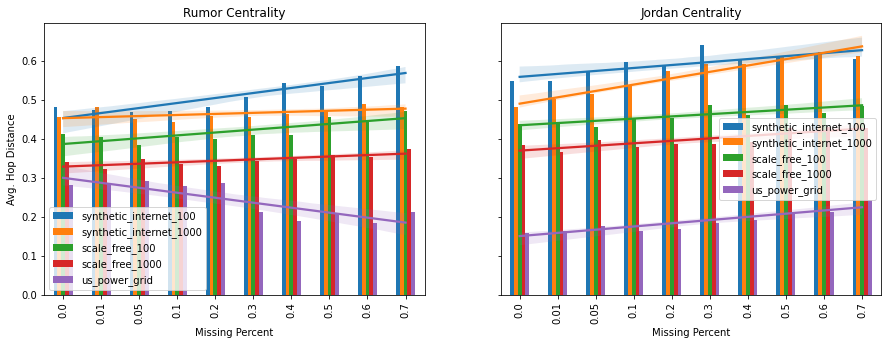

In [18]:
plot_rumor_against_jordan(diameter_normalized_results, "si", "30p")

# Rumor vs Jordan - 30p - Various simulations

/tmp/ipykernel_7002/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


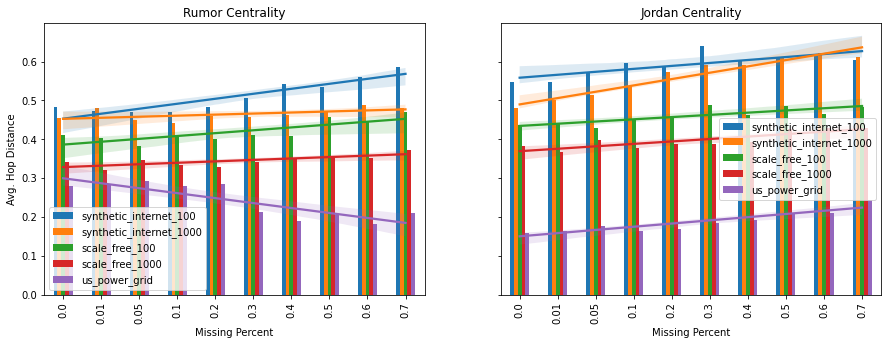

In [19]:
plot_rumor_against_jordan(diameter_normalized_results, "si", "30p")

/tmp/ipykernel_7002/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


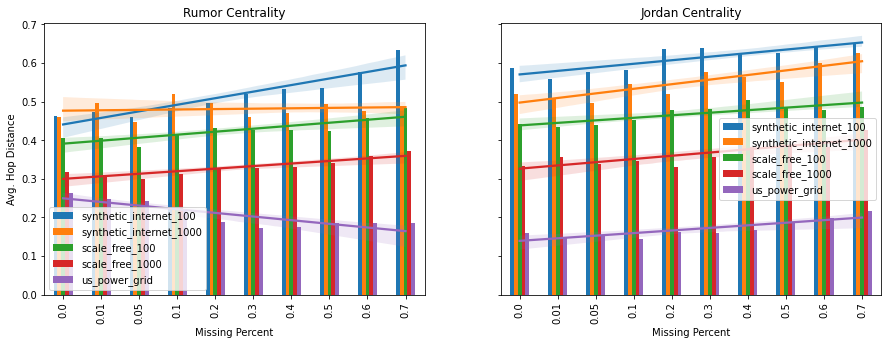

In [20]:
plot_rumor_against_jordan(diameter_normalized_results, "sis", "30p")

/tmp/ipykernel_7002/2052612487.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


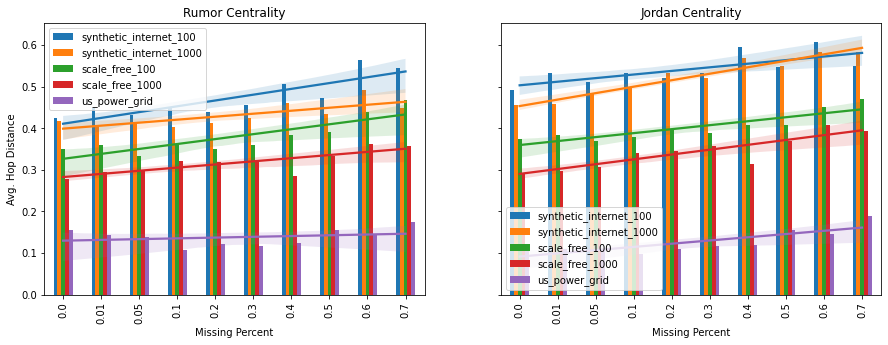

In [21]:
plot_rumor_against_jordan(diameter_normalized_results, "sir", "30p")

In [72]:
r = load_results("30p", "si", "us_power_grid")

In [84]:
from rumor_centrality.graph_visualization import plot_nx_graph
import networkx as nx

In [106]:
diameters_over_p = {}
avg_degree_over_p = {}
for p in tqdm([0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    diameters_over_p[p] = nx.diameter(r[p][0]["ex_graph"])
    avg_degree_over_p[p] = len(r[p][0]["ex_graph"].edges) / len(r[p][0]["ex_graph"].nodes)

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


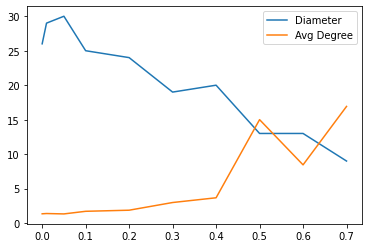

In [110]:
plt.plot(diameters_over_p.keys(), diameters_over_p.values(), label="Diameter")
plt.plot(avg_degree_over_p.keys(), avg_degree_over_p.values(), label="Avg Degree")
plt.legend()